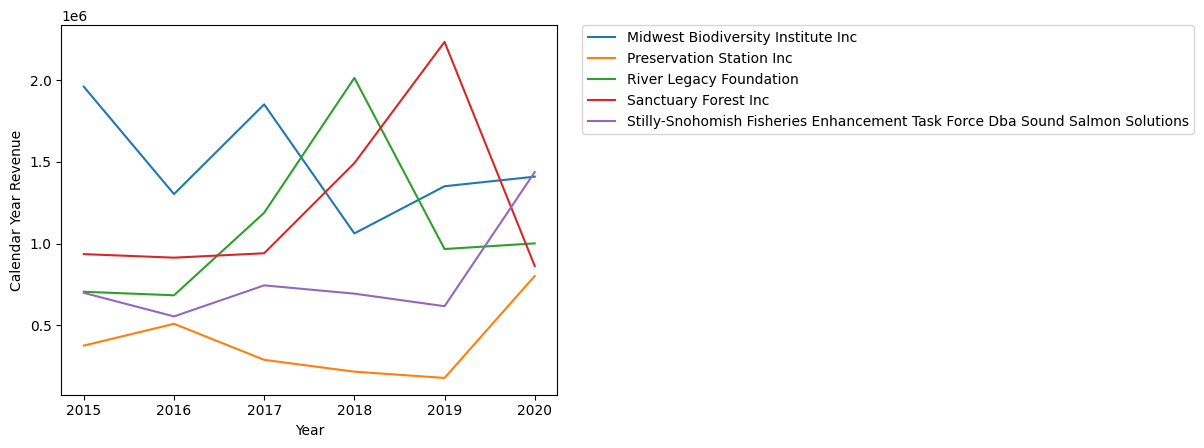

In [26]:
# Michael Berbach
import pandas as pd
import matplotlib.pyplot as plt

fnam = 'serOutTes.csv'
df = pd.read_csv(fnam, header=None)
df.columns = ['name', 'revenue', 'year']


unique_names = []
for name in df['name'].unique():
    name_filter = df['name'] == name
    name_df = df.loc[name_filter].copy()
    if set(name_df['year']) >= set(range(2015, 2021)):
        unique_names.append(name)
    if len(unique_names) == 5:
        break

# Create a new DataFrame with the rows for the selected unique names
result_df = pd.DataFrame(columns=['name', 'year', 'revenue'])
for name in unique_names:
    name_filter = df['name'] == name
    name_df = df.loc[name_filter].copy()
    result_df = pd.concat([result_df, name_df], axis=0)

fig, ax = plt.subplots()

for name, group in result_df.groupby('name'):
    group = group.sort_values('year')
    ax.plot(group['year'], group['revenue'], label=name)

ax.legend()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.set_xlabel('Year')
ax.set_ylabel('Calendar Year Revenue')
plt.show()

## 1. Plot
    The graph above shows five environmentally oriented non-profits. It graphs their total calendar year revenue on the y-axis, per tax return year across the x-axis. These were selected from a large group based on the uniform availability of data across the years.
## 2. Regex
    I used the regex pattern r'native plant|biodiversity|wildlife' to filter for environmentally oriented non-profits. I did not have success applying mutiple regex filters. While it was a bit wider of a filter than I would have liked, ultimately it did a sufficently good job of generating a list of non-profits that were essentially all environmentally related. Issue was more to do with shear number of results than their relevance. Also kind of interesting: A lot of the organizations are west coast/California associated.
## 3. XPATH
    I applied that pattern to the mission description node, the activity or mission description node, and the description node. I figured if all three of those nodes contained relevant verbiage it would be surefire that the organization was environmentally oriented. I chose the node for calendar year total revenue as the metric of importance as it is a clear quantifier on the size of the organization. Furthermore it can be an easy to read indicator of financial health over time for an organization.
## 4. Parallel Programming

![32CoreSpeed](Screenshot%202023-04-17%20221633.png)
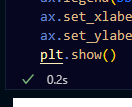
    
    Using 32 cores the total run time was no more than 1 minute and 12 seconds. I ran my script in parallel using bash. I read off the relevant file names at the correct directory int GNU Parallel as system arguments for my python script. It then printed the parsed xml files in a tabular for of name, revenue, year. This was then read from standard out into a .csv file. It was nearly a zip file per core, processing almost all the chunks at once.

# Appendix

## noProfit.sh

```
#!/bin/bash

time ls /stat129/download990xml_20*.zip | parallel 'python3 noProfit129v4ser.py {}' > serOutTes.csv

```


## noProfit129v4ser.py
```
import zipfile
from lxml import etree
import sys
import re

# read zip file path from standard input, now accepting as args from GNU Par.
zstr = sys.argv[1]
zp = zipfile.ZipFile(zstr)
fnames = zp.namelist()
#mt = 0
ns = {'irs':'http://www.irs.gov/efile'}


def anvil(tree):
    misDsc = str(tree.xpath('//irs:ReturnData/irs:IRS990/irs:MissionDesc/text()', namespaces = ns))
    actMisDsc = str(tree.xpath('//irs:ReturnData/irs:IRS990/irs:ActivityOrMissionDesc/text()', namespaces = ns))
    dsc = str(tree.xpath('//irs:ReturnData/irs:IRS990/irs:Desc/text()', namespaces = ns))
    lst = [misDsc,actMisDsc,dsc]
    #print(lst)
    patUn = re.compile(r'native plant|biodiversity|wildlife', flags=re.IGNORECASE)
    #patDi = re.compile(r'native plant|natural habitat',flags=re.IGNORECASE)
    swch = 0
    #patTri = re.compile(,re.IGNORECASE)
    
    for txt in lst:
        matchUn = re.search(patUn,txt)
        #matchDi = re.search(patDi,txt)
        if matchUn != None and swch == 0:
        
            swch = 1
            snam = etch(tree)
            matchUn = re.search(r"\d{4}",zstr)
            yrstr = matchUn.group()
            cyrev = str(tree.xpath('//irs:ReturnData/irs:IRS990/irs:CYTotalRevenueAmt/text()', namespaces = ns))
            cyrev = cyrev[2:-2]
            if len(snam) > 2:
                print(snam+','+ cyrev +','+yrstr)


def etch(tree):
    txt = ''

    s1nam = str(tree.xpath('//irs:Filer/irs:BusinessName/irs:BusinessNameLine1Txt/text()', namespaces = ns))
    s1nam = s1nam[2:-2].lower().title()

    s2nam = str(tree.xpath('//irs:Filer/irs:BusinessName/irs:BusinessNameLine2Txt/text()', namespaces = ns))
    s2nam = s2nam[2:-2].lower().title()

    if len(s2nam) != 0:
        txt = s1nam + " " + s2nam
    else:
        txt = s1nam

    return txt.strip()


def xtract(fname):    
    f = zp.open(fname)
    tree = etree.parse(f)

    anvil(tree)
    

def gogo():
    for x in fnames:
        xtract(x) 
    print()
gogo()
```